<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

[Проект на kaggle](https://www.kaggle.com/laysanmart/baseline-sf-dst-car-price-prediction-v16), здесь можно посмотреть спарсенные данные

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from  xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/df-train-cars/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

df-train-cars			       sf-dst-car-price-prediction
parsing-all-moscow-auto-ru-09-09-2020


парсилсь даные по городам, потом объединила, [ссылка на весь датaсет](https://drive.google.com/file/d/1JIgAWuZW9psdFiguebAQQxUI3XVRAX23/view?usp=sharing)

In [8]:
train = pd.read_csv(DIR_TRAIN+'df_train_cars.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(5)

,car_url,brand,bodyType,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,city
0,https://auto.ru/cars/used/sale/skoda/octavia/1...,SKODA,лифтбек,золотистый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152.0,"{'cruise-control': True, 'esp': True, 'airbag-...",Бензин,177000.0,...,автоматическая,EUROPEAN,4.0,Оригинал,передний,Левый,Не требует ремонта,Растаможен,540000.0,Москва
1,https://auto.ru/cars/used/sale/skoda/rapid/110...,SKODA,лифтбек,серый,НЕ ТАКСИ ! НЕ БИТАЯ И НЕ КРАШЕНАЯ ! Хорошая ко...,1.6 LTR,110.0,"{'cruise-control': True, 'esp': True, 'usb': T...",Бензин,23000.0,...,автоматическая,EUROPEAN,1.0,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1610000.0,Москва
2,https://auto.ru/cars/used/sale/skoda/octavia_r...,SKODA,лифтбек,серый,2 Владелец \nДокументы Оригинал \nКомплект Клю...,2.0 LTR,200.0,"{'cruise-control': True, 'esp': True, 'airbag-...",Бензин,221000.0,...,роботизированная,EUROPEAN,2.0,Оригинал,передний,Левый,Не требует ремонта,Растаможен,960000.0,Москва
3,https://auto.ru/cars/used/sale/skoda/octavia_r...,SKODA,лифтбек,зелёный,Продам Skoda Octavia RS (200 л.с) 2012 года вы...,2.0 LTR,200.0,"{'cruise-control': True, 'asr': True, 'tinted-...",Бензин,240000.0,...,роботизированная,EUROPEAN,4.0,Дубликат,передний,Левый,Не требует ремонта,Растаможен,1190000.0,Москва
4,https://auto.ru/cars/used/sale/skoda/octavia/1...,SKODA,лифтбек,чёрный,"Авто в хорошем состоянии,что было сделано по д...",2.0 LTR,140.0,"{'cruise-control': True, 'tinted-glass': True,...",Дизель,275000.0,...,роботизированная,EUROPEAN,3.0,Дубликат,передний,Левый,Не требует ремонта,Растаможен,660000.0,Москва


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48383 entries, 0 to 48382
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_url              48383 non-null  object 
 1   brand                48383 non-null  object 
 2   bodyType             48383 non-null  object 
 3   color                48383 non-null  object 
 4   description          48383 non-null  object 
 5   engineDisplacement   48383 non-null  object 
 6   enginePower          47799 non-null  float64
 7   equipment_dict       48383 non-null  object 
 8   fuelType             47968 non-null  object 
 9   mileage              47968 non-null  float64
 10  modelDate            48383 non-null  float64
 11  model_name           48383 non-null  object 
 12  numberOfDoors        48383 non-null  float64
 13  parsing_unixtime     48383 non-null  float64
 14  priceCurrency        48383 non-null  object 
 15  productionDate       48383 non-null 

In [11]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

отчет из pandas profiling загрузила на гитхаб
судя по нему у нас 21 категориальный признак и 6 числовых
milege нужно попробовать прологарифмировать
priceCurrency не нужный признак, валюта везде одна
Состояние и таможня тоже везде одинаковые, пропусков почти нет
price нужно попробовать прологарифмировать
высокая корреляция у prodactionDate и ModelDate, логично, посмотрим их дальше поближе
высокая отрицательная корреляция у modeldate и milage, тоже логично
все равно все данные после объединения с тестом посмотрим заново

[Парсинг данных смотреть на GitHub](https://github.com/LaysanMart/Skillfactory/blob/master/module%207/%D0%9F%D0%B0%D1%80%D1%81%D0%B8%D0%BD%D0%B3%20%D1%87%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%B8%D0%BA-%D0%95%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B1%D1%83%D1%80%D0%B3.ipynb)

## EDA

In [13]:
train['sample'] = 1 # помечаем где у нас трейн

test['sample'] = 0 # помечаем где у нас тест

train['sell_id'] = 0 # в трейне нет этого значения, добавин нулевые

test['city'] = 'Москва'

test['price'] = 0 # эту цену нужно предвидеть

In [14]:
columns = train.columns.to_list() # чтобы объединить трейн и тест сделаем чтобы у них были одни и те же колонки

In [15]:
test_df = test[columns]

In [16]:
data = test_df.append(train, sort=False).reset_index(drop=True) # объединяем

In [17]:
cat_cols = []

num_cols = []

bin_cols = [] # по мере обработки признаков списки будем заполнять

unknown_cols = list()


## bodyType

In [18]:
common_bodyType = (data['bodyType'].value_counts(

)[data['bodyType'].value_counts(normalize=True) > 0.005]).to_dict() # словарь с наиболее часто встречающимися типами кузова

list_bodyType = list(common_bodyType.keys()) 

list_bodyType # выделим наиболее распространенные значения типа кузова

['внедорожник 5 дв.',
 'седан',
 'лифтбек',
 'хэтчбек 5 дв.',
 'универсал 5 дв.',
 'минивэн',
 'купе',
 'компактвэн',
 'хэтчбек 3 дв.',
 'седан long',
 'пикап двойная кабина']

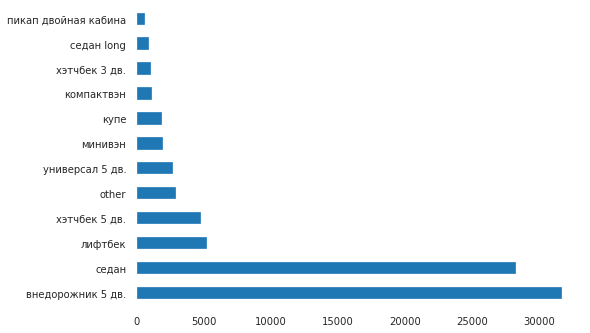

In [19]:
# редкие заменим на 'other'

data.bodyType = data.bodyType.apply(lambda x: x if x in list_bodyType else 'other') 

data.bodyType.value_counts().plot.barh()

#пропусков нет, добавим признак к категоральным

cat_cols.append('bodyType')

## brand

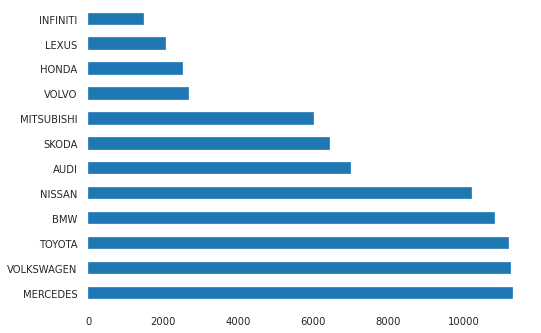

In [20]:

data.brand.value_counts().plot.barh()

In [21]:
cat_cols.append('brand') # признак не имеет пропусков, добавим в наш список

In [22]:
# можно выделитть дорогие бренды автомобилей в бинарный признак
exp_brand = ['MERCEDES', 'BMW', 'AUDI', 'LEXUS', "INFINITI", 'VOLVO']

In [23]:
data['exp_brand'] = data.brand.apply(lambda x: 1 if x in exp_brand else 0)

In [24]:
bin_cols.append('exp_brand')

## color

In [25]:
data.color.value_counts(normalize=True) # по отчету пропусков тоже нет, добавим в список

чёрный         0.307034
белый          0.200183
серый          0.127099
серебристый    0.107056
синий          0.093055
красный        0.042988
коричневый     0.042675
зелёный        0.023715
бежевый        0.017973
голубой        0.010955
пурпурный      0.006705
золотистый     0.006200
фиолетовый     0.005465
жёлтый         0.004875
оранжевый      0.003744
розовый        0.000277
Name: color, dtype: float64

In [26]:
cat_cols.append('color')

In [27]:
common_color = ['чёрный', 'белый', 'серый', 'серебристый']

In [28]:
data['common_color'] = data.color.apply(lambda x: 1 if x in common_color else 0)

In [29]:
bin_cols.append('common_color')

## description

In [30]:
data.description # описание машин, пока оставим

0        Все автомобили, представленные в продаже, прох...
1        ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...
2        Все автомобили, представленные в продаже, прох...
3        КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...
4        ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...
                               ...                        
83064    Продам. В отличном состоянии! С машиной отдам ...
83065    Пробег 80 500 км. подтвержденный. \n\nЭто макс...
83066    Автомобиль полностью исправен, в хорошем состо...
83067    Автомобиль в отличном состоянии, как по кузову...
83068    Автомобиль отс.крашен бампер. Двигатель отс. М...
Name: description, Length: 83069, dtype: object

In [31]:
unknown_cols.append('description')

можно добавить длину описания

In [32]:
data['len_descr'] = 0
for i in range(0, len(data.description)):
    data['len_descr'][i] = len(data.description[i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


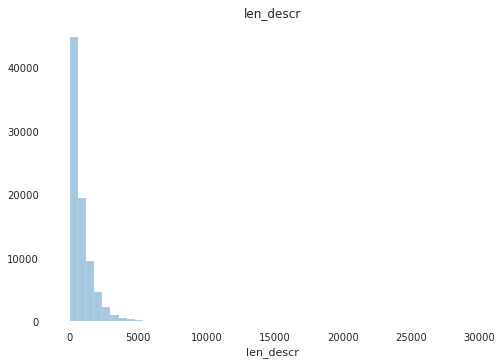

In [33]:
plt.figure()

sns.distplot(data['len_descr'], kde = False, rug=False)

plt.title('len_descr')

plt.show()

In [34]:
data['len_descr'] = np.log(data.len_descr + 1)

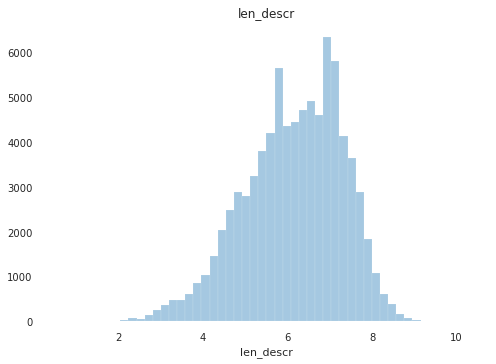

In [35]:
plt.figure()

sns.distplot(data['len_descr'], kde = False, rug=False)

plt.title('len_descr')

plt.show()

In [36]:
num_cols.append('len_descr')

## engineDisplacement

In [37]:
data.engineDisplacement.value_counts() 

2.0 LTR    19966
1.6 LTR    10796
3.0 LTR    10023
1.8 LTR     6073
2.5 LTR     5511
1.4 LTR     4082
3.5 LTR     3706
2.4 LTR     3348
1.5 LTR     2117
4.0 LTR     1246
1.2 LTR     1220
4.4 LTR     1044
2.1 LTR     1035
2.2 LTR      949
1.3 LTR      909
2.8 LTR      873
5.5 LTR      860
4.7 LTR      800
4.5 LTR      795
1.9 LTR      704
3.2 LTR      683
2.7 LTR      656
4.2 LTR      531
2.3 LTR      454
2.9 LTR      449
3.6 LTR      399
3.7 LTR      379
5.6 LTR      346
5.7 LTR      336
5.0 LTR      333
4.6 LTR      317
1.0 LTR      277
6.0 LTR      174
4.8 LTR      161
4.1 LTR      152
0.7 LTR      140
3.3 LTR      137
3.4 LTR      133
2.6 LTR      120
3.8 LTR      119
3.1 LTR      116
1.7 LTR      114
0.0 LTR       92
4.3 LTR       72
6.2 LTR       56
5.4 LTR       55
 LTR          55
5.9 LTR       28
4.9 LTR       26
6.3 LTR       25
5.2 LTR       19
1.1 LTR       15
6.6 LTR       15
5.8 LTR       14
3.9 LTR        9
9.0 LTR        2
0.5 LTR        1
7.0 LTR        1
5.3 LTR       

Есть пустое значение, заменим его на самое частое

In [38]:
for i in range(0, len(data.engineDisplacement)):

    if len(data.engineDisplacement[i]) < 7:

        data.engineDisplacement[i] = data.engineDisplacement.value_counts().keys()[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [39]:
cat_cols.append('engineDisplacement')

## enginePower

In [40]:
data.enginePower.value_counts()

# сделаем из мощности двигателя номинальный признак

150.0      3405
249.0      2327
110.0      1882
249 N12    1708
150 N12    1699
           ... 
301 N12       1
303 N12       1
349.0         1
338 N12       1
34.0          1
Name: enginePower, Length: 653, dtype: int64

In [41]:
for i in range(0, len(data.enginePower)):

    if type(data.enginePower[i]) is not float:

        data.enginePower[i] = float(data.enginePower[i][:3])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [42]:
data['enginePower'] = data['enginePower'].apply(pd.to_numeric, errors='coerce')

In [43]:
data.loc[data['enginePower'].isna(), 'enginePower'] = data.enginePower.median() #заменим пропущенные значения медианой

In [44]:
num_cols.append('enginePower')

## equipment_dict

In [45]:
data.equipment_dict

# тоже признак с доп. опциями, пока оставим

0        {"engine-proof":true,"tinted-glass":true,"airb...
1        {"cruise-control":true,"asr":true,"esp":true,"...
2        {"cruise-control":true,"tinted-glass":true,"es...
3        {"cruise-control":true,"roller-blind-for-rear-...
4        {"cruise-control":true,"asr":true,"esp":true,"...
                               ...                        
83064    {'cruise-control': True, 'engine-proof': True,...
83065    {'cruise-control': True, 'tinted-glass': True,...
83066    {'cruise-control': True, 'engine-proof': True,...
83067    {'engine-proof': True, 'roller-blind-for-rear-...
83068                                                   {}
Name: equipment_dict, Length: 83069, dtype: object

In [46]:
unknown_cols.append('equipment_dict')

## fuelType

In [47]:
data.fuelType.value_counts()

Бензин          32272
бензин          28601
Дизель          13691
дизель           5800
Гибрид           1209
оборудование      557
гибрид            223
Электро           129
Газ               110
электро            55
газ                 7
Name: fuelType, dtype: int64

In [48]:
data.fuelType = data.fuelType.str.lower()

In [49]:
data.fuelType = data.fuelType.fillna('бензин') # как самый распространенный тип топлива

In [50]:

cat_cols.append('fuelType')

## mileage

Распределение близко к нормальному, с правым хвостом, возможно, логарифмирование поможет приблизиться к нормальному распределению

In [51]:
data.loc[data['mileage'].isna(), 'mileage'] = data.mileage.median()

num_cols.append('mileage')

In [52]:
data['mileage_log'] = np.log(data.mileage + 1)

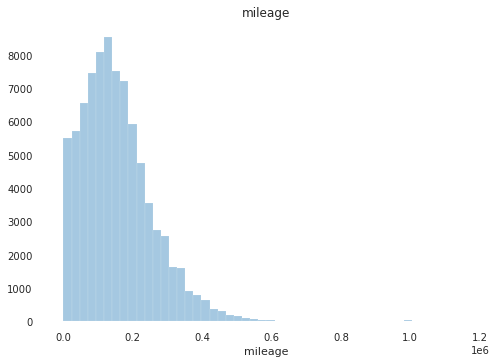

In [53]:
plt.figure()

sns.distplot(data['mileage'], kde = False, rug=False)

plt.title('mileage')

plt.show()


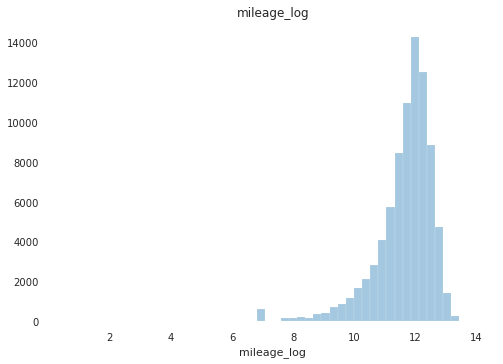

In [54]:
plt.figure()

sns.distplot(data['mileage_log'], kde = False, rug=False)

plt.title('mileage_log')

plt.show()

In [55]:
num_cols.append('mileage_log')

## modelDate

In [56]:
#пропусков нет, добавим в список

num_cols.append('modelDate')

## productionDate

In [57]:
# заменим слишком старые машины на год посвежее

len(data[data['productionDate'] < 1960])
#Всего 25 машин старше 1960 года

25

In [58]:
data.loc[data['productionDate'] < 1960, 'productionDate'] = 1960

In [59]:
num_cols.append('productionDate')

Распределение почти такое же как у modelDate, возможно, лучше будет оставить только один из признаков

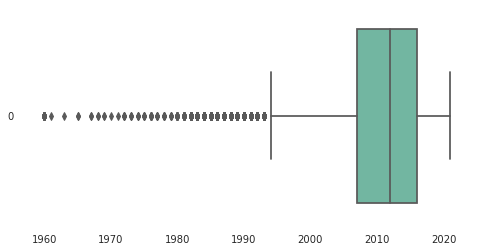

In [60]:
#Посмотрим на boxplot

plt.figure(figsize=(8, 4))

sns.boxplot(data=data['productionDate'], orient="h",

                 palette="Set2", whis=1.5);



In [61]:
perc25 = data.productionDate.quantile(0.25)

perc75 = data.productionDate.quantile(0.75)

IQR = perc75 - perc25

f=perc25 - 1.5*IQR

print(perc25, perc75, f)

2007.0 2016.0 1993.5


Хотела добавить новый признак, но он ухудшил качество модели, оставила как есть
Добавим новый признак, младше 2016 - new, 2007-20016 - not_new, 1993-2007 old, младше 1993 - very old

data['age']=0

data.reset_index(inplace=True)

for i in range(0, len(data.productionDate)):

    if data.productionDate[i] >= 2016:

        data['age'][i] = 'new'

    elif data.productionDate[i] < 2016 and data.productionDate[i] >= 2007:

        data['age'][i] = 'not_new'

    elif data.productionDate[i] < 2007 and data.productionDate[i] >= 1993:

        data['age'][i] = 'old'

    elif data.productionDate[i] < 1993:

        data['age'][i] = 'very_old'

data['age'].value_counts()

cat_cols.append('age')

## model_name

In [62]:
cat_cols.append('model_name')

## numberOfDoors

In [63]:
num_cols.append('numberOfDoors')

## parsing_unixtime

In [64]:
num_cols.append('parsing_unixtime')

## super_gen

In [65]:
data[data['sample']==0]['super_gen'][0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [66]:
data[data['sample']==1]['super_gen'][35000]

"{'gear_type': 'FORWARD_CONTROL', 'engine_type': 'GASOLINE', 'transmission': 'ROBOT', 'id': '10373615', 'displacement': 1798, 'power': 180, 'power_kvt': 132, 'human_name': '1.8 AMT (180 л.с.)', 'acceleration': 7.4, 'clearance_min': 155, 'fuel_rate': 6.1}"

In [67]:
unknown_cols.append('super_gen')

## vehicleTransmission

In [68]:
data['vehicleTransmission'].value_counts()

автоматическая      43913
механическая        20815
роботизированная     9060
вариатор             8866
Name: vehicleTransmission, dtype: int64

In [69]:
data['vehicleTransmission']=data['vehicleTransmission'].fillna('автоматическая')

In [70]:
cat_cols.append('vehicleTransmission')

## Владельцы

In [71]:
data['Владельцы'].value_counts()

3 или более    15957
1.0            15526
2.0            11547
4.0            10839
3.0            10055
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [72]:
def convert_to_int(data):

    for s in re.findall('\d', str(data)):

        s = int(s)

        return s

In [73]:
data['Владельцы'] = data['Владельцы'].apply(convert_to_int)

data['Владельцы'].value_counts()

3.0    26012
1.0    24985
2.0    20817
4.0    10839
Name: Владельцы, dtype: int64

In [74]:
# если не указано предполагаем худшее

data['Владельцы'] = data['Владельцы'].fillna(3)

data.loc[data['Владельцы'] > 3, 'Владельцы'] = 3

In [75]:
num_cols.append('Владельцы')

## Привод

In [76]:
data['Привод'] = data['Привод'].fillna('полный') 

In [77]:
cat_cols.append('Привод')

## vendor

In [78]:

data['vendor'].value_counts() 

EUROPEAN    49531
JAPANESE    33531
AMERICAN        7
Name: vendor, dtype: int64

In [79]:
cat_cols.append('vendor')

## ПТС

In [80]:
data['ПТС'] = data['ПТС'].fillna("Оригинал")

In [81]:
bin_cols.append('ПТС')

## Руль

In [82]:
data['Руль'] = data['Руль'].fillna("Левый")

In [83]:
bin_cols.append('Руль')

## city

In [84]:
cat_cols.append('city')

cols = ['sample', 'sell_id', 'price']

## price
Ценана машины за год изменилась в среднем на 25-30%

In [85]:
data.price = data.apply(lambda x: x.price if x.price == 0 else x.price * 0.8, axis=1)

## Посмотрим на значимость колонок в списках (cat_cols, bin_cols, num_cols)

In [86]:
train_1=data[data['sample'] == 1]
train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48383 entries, 34686 to 83068
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_url              48383 non-null  object 
 1   brand                48383 non-null  object 
 2   bodyType             48383 non-null  object 
 3   color                48383 non-null  object 
 4   description          48383 non-null  object 
 5   engineDisplacement   48383 non-null  object 
 6   enginePower          48383 non-null  float64
 7   equipment_dict       48383 non-null  object 
 8   fuelType             48383 non-null  object 
 9   mileage              48383 non-null  float64
 10  modelDate            48383 non-null  float64
 11  model_name           48383 non-null  object 
 12  numberOfDoors        48383 non-null  float64
 13  parsing_unixtime     48383 non-null  float64
 14  priceCurrency        48383 non-null  object 
 15  productionDate       48383 non-n

Text(0.5, 1.0, 'Significance of num variables')

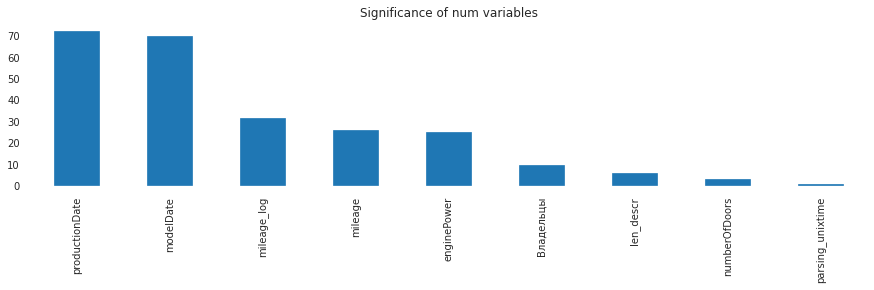

In [87]:
num_cols = pd.Series(
    f_classif(
        train_1[num_cols],
        train_1["price"],
    )[0],
    index=num_cols,
)
num_cols.sort_values(inplace=True, ascending=False)
num_cols.plot(kind="bar", figsize=(15, 3))
plt.title("Significance of num variables")

т.к. коррелция между modelDate и productionDate по отчету большая, оставим признак, который больше влияет на модель
еще большая корреляция между mileage и productionDate, что логично, чем старше машина, тем больше пробег, 
попробовала создать признак на основе этих двух, качество модели нне улучшилось

In [88]:
#data['mileage_year'] = 0

#data['mileage_per_year'] = 0

#for i in range(0, len(data.productionDate)):
#
#    data['mileage_year'][i] = data.mileage[i]/(data.productionDate[i])
#
#for i in range(0, len(data.productionDate)):
#
#    if data.productionDate[i] != 2021:
#
#        data['mileage_per_year'][i] = data.mileage[i]/(2021.0 - data.productionDate[i])
#
#    else:
#
#        data['mileage_per_year'][i] = data.mileage[i]

In [89]:
for colum in cat_cols:
    train_1[colum] = train_1[colum].astype('category').cat.codes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
label_encoder = LabelEncoder()
for column in bin_cols:
    train_1[column] = label_encoder.fit_transform(train_1[column])
    print(dict(enumerate(label_encoder.classes_)))

{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 'Дубликат', 1: 'Оригинал'}
{0: 'Левый', 1: 'Правый'}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


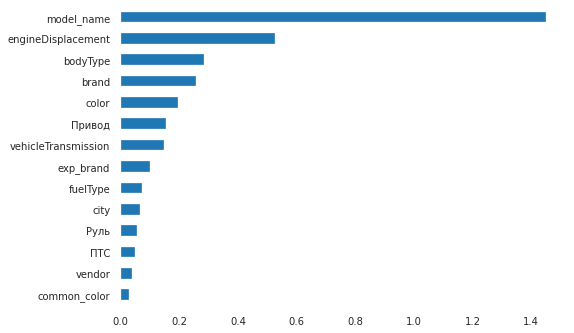

In [91]:
imp_cat = Series(mutual_info_classif(train_1[bin_cols + cat_cols], train_1['price'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [92]:
cat_cols = ['model_name', 'engineDisplacement',
 'bodyType',
 'brand',
 'color',
 'vehicleTransmission', 'Привод', 'fuelType','exp_brand']

In [93]:
columns = ['model_name',
 'engineDisplacement',
 'productionDate',
 'bodyType',
 'brand',
 'color',
 'vehicleTransmission',
 'Привод',
 'fuelType',
 'mileage_log',
 'enginePower',
 'exp_brand',
 'len_descr',
 'sample',
 'sell_id',
 'price']

In [94]:
num_cols = ['productionDate', 'mileage_log', 'enginePower', 'len_descr']

Полиноминальные признаки ничего не дали.

In [95]:
train_1 = train_1[columns]

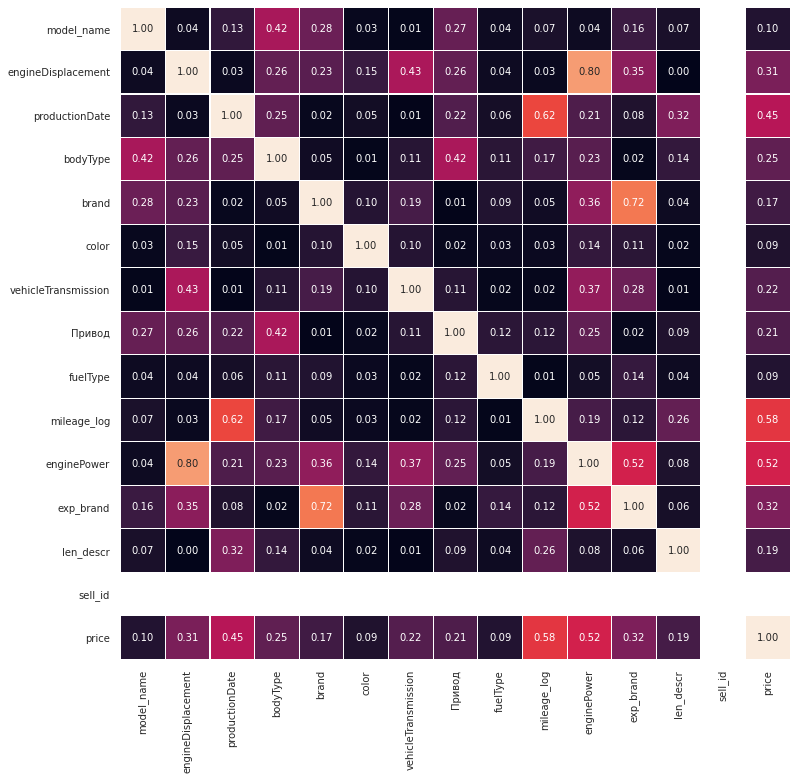

In [96]:
plt.rcParams['figure.figsize'] = (12,12)
sns.heatmap(train_1.drop(['sample'], axis=1).corr().abs(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)

In [97]:
columns.remove('engineDisplacement')

In [98]:
cat_cols.remove('engineDisplacement')

## Data Preprocessing

In [99]:
data = data[cat_cols+num_cols+cols]

In [100]:
train = data[data['sample'] == 1] # помечаем где у нас трейн
test = data[data['sample'] == 0] # помечаем где у нас тест

In [101]:
train.dropna(subset=['productionDate','mileage_log'], inplace=True)
train.dropna(subset=['price'], inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
# для baseline просто возьму пару схожих признаков без полной обработки
columns = columns
df_train = train[columns]
df_test = test[columns]

In [103]:
y = train['price']

## Label Encoding

In [104]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [105]:
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

In [106]:
data

,model_name,productionDate,bodyType,brand,color,vehicleTransmission,Привод,fuelType,mileage_log,enginePower,exp_brand,len_descr,sample,sell_id,price
0,360,2014.0,4,8,13,3,1,0,11.211834,105.0,0,6.909753,0,1100575026,0.0
1,360,2017.0,4,8,15,2,1,0,11.011456,110.0,0,7.867106,0,1100549428,0.0
2,519,2014.0,4,8,12,3,1,0,11.385103,152.0,0,6.909753,0,1100658222,0.0
3,360,2014.0,4,8,6,0,1,0,11.461643,110.0,0,7.424762,0,1100937408,0.0
4,360,2012.0,4,8,1,0,1,0,10.977414,152.0,0,7.768956,0,1101037972,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83064,294,2008.0,7,6,0,0,1,0,12.170451,109.0,0,6.481577,1,0,416000.0
83065,374,2014.0,1,6,11,0,2,3,11.302217,178.0,0,6.872128,1,0,1512000.0
83066,368,2007.0,1,6,12,2,2,3,12.487489,156.0,0,5.934894,1,0,720000.0
83067,225,1989.0,11,6,11,0,1,0,12.694656,86.0,0,5.393628,1,0,64000.0


In [107]:
X = data.query('sample == 1').drop(['sample','price'], axis=1)
X_sub = data.query('sample == 0').drop(['sample', 'price'], axis=1)

## Train Split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [109]:
#tmp_train = X_train.copy()
#tmp_train['price'] = y_train

In [110]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
#predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
#print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [111]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [112]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 18.29%


Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [113]:
np.log(y_train)

44532    13.631588
56268    13.714585
73071    13.114331
38036    11.982929
47039    13.235692
           ...    
45970    13.530492
79418    13.847009
72844    12.994530
35546    14.105191
50481    14.319916
Name: price, Length: 38706, dtype: float64

In [114]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [115]:
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

In [116]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 15.55%


Как видим точность возросла до 15%

ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train, np.log(y_train))

predict = np.exp(reg.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 21.66%

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [100, 150, 200, 250, 300, 350, 400, 450, 500]

max_features = ['auto', 'sqrt']

max_depth = [10, 15, 20, 25]

max_depth.append(None)

min_samples_split = [2,3,4,5,6,7,8,9,10]

min_samples_leaf = [1,2,3,4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,

               'max_features': max_features,

               'max_depth': max_depth,

               'min_samples_split': min_samples_split,

               'min_samples_leaf': min_samples_leaf,

               'bootstrap': bootstrap}

​

model_random = RandomizedSearchCV(estimator=reg, param_distributions=random_grid, n_iter=10, 

                               cv=3, verbose=2, random_state=42, n_jobs=-1)

model_random.fit(X_train, y_train)

​

model_random.best_params_

​

​

Fitting 3 folds for each of 10 candidates, totalling 30 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished

{'n_estimators': 400,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 25,
 'bootstrap': False}

reg = ExtraTreesRegressor(random_state=RANDOM_SEED, 

                            n_jobs=-1, 

                            verbose=1, 

                            n_estimators = 400, 

                            min_samples_split = 9, 

                            min_samples_leaf = 2, 

                            max_features = 'auto', 

                            max_depth = 25, 

                            bootstrap = False)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

​

​

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s

Точность модели по метрике MAPE: 21.60%

[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished

reg.fit(X_train, np.log(y_train))

y_pred = np.exp(reg.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s

Точность модели по метрике MAPE: 18.62%

[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished

Не очень то настройка гиперпараметров помогла
RandomForestRegressor

rfr = RandomForestRegressor(random_state=RANDOM_SEED)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 23.40%

rfr.fit(X_train, np.log(y_train))

y_pred = np.exp(rfr.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 20.38%

n_estimators = [100, 150, 200, 250, 300, 350, 400]

max_features = ['auto', 'sqrt']

max_depth = [10, 15, 20, 25]

min_samples_split = [2, 4, 6, 8, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,

               'max_features': max_features,

               'max_depth': max_depth,

               'min_samples_split': min_samples_split,

               'min_samples_leaf': min_samples_leaf,

               'bootstrap': bootstrap}

​

​

model_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=10, 

                               cv=3, verbose=2, random_state=42, n_jobs=-1)

model_random.fit(X_train, y_train)

​

​

Fitting 3 folds for each of 10 candidates, totalling 30 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400]},
                   random_state=42, verbose=2)

model_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 25,
 'bootstrap': False}

rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,verbose=1, n_estimators=100,

                             min_samples_split=10, min_samples_leaf=2, max_features='sqrt',

                             max_depth=25, bootstrap=False)

​

rfr.fit(X_train, np.log(y_train))

​

y_pred = np.exp(rfr.predict(X_test))

​

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s

Точность модели по метрике MAPE: 19.16%

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished

GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=RANDOM_SEED).fit(X_train, np.log(y_train))

y_pred = np.exp(model.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 22.94%

​

BaggingRegressor

from sklearn.ensemble import BaggingRegressor

from sklearn.datasets import make_regression

model = RandomForestRegressor(random_state=RANDOM_SEED).fit(X_train, np.log(y_train))

y_pred = np.exp(model.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 20.38%


## Попытка стекинга

In [117]:
estimators = [
    ('cat', CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )),
    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, 
                            n_jobs=-1, 
                            verbose=1, 
                            n_estimators = 400, 
                            min_samples_split = 9, 
                            min_samples_leaf = 2, 
                            max_features = 'auto', 
                            max_depth = 25, 
                            bootstrap = False)),
    ('xgb', XGBRegressor(random_state=RANDOM_SEED)),
    ]

stack_log = StackingRegressor(estimators=estimators,
                              final_estimator=LinearRegression()
                              )

stack_log.fit(X_train, np.log(y_train))

y_pred = np.exp(stack_log.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | ela

Точность модели по метрике MAPE: 15.50%.


In [118]:
predict_submission = np.exp(stack_log.predict(X_sub))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.9s finished


# Submission

In [119]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,8.405091e+05
1,1100549428,1.237893e+06
2,1100658222,1.017500e+06
3,1100937408,8.555543e+05
4,1101037972,8.187319e+05
5,1100912634,7.793264e+05
6,1101228730,7.268597e+05
7,1100165896,5.194862e+05
8,1100768262,2.392234e+06
9,1101218501,8.161550e+05


В итоге получили **MAPE 20%** на ЛБ!


# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing